In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import splitfolders
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
%cd /Users/irfanmasudi/ANNDL/Challenge/

/Users/irfanmasudi/ANNDL/Challenge


In [4]:
# Dataset folders 
dataset_dir = 'datasets'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [5]:
#Create a Label
labels = ['Apple',       # 0
          'Blueberry',   # 1
          'Cherry',      # 2
          'Corn',        # 3
          'Grape',       # 4
          'Orange',      # 5
          'Peach',       # 6
          'Pepper',      # 7
          'Potato',      # 8
          'Raspberry',   # 9
          'Soybean',     # 10
          'Squash',      # 11
          'Strawberry',  # 12
          'Tomato']   

In [6]:
#import Inception-ResNet Architecture using pretrained weight and exclude top layers
incresnet = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet'
)

In [7]:
#Read data train and and validation from directory, without implementing data augemtation because we implement second scenario, 
#Balanced data for each class

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Preprocessing Input 
noaug_train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.inception_resnet_v2.preprocess_input)
valid_data_gen       = ImageDataGenerator(preprocessing_function=tfk.applications.inception_resnet_v2.preprocess_input)

train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(299,299),
                                                           color_mode='rgb',
                                                           classes=None,
                                                           class_mode='categorical',
                                                           batch_size=64,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(299,299),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False,
                                               seed=seed)

Found 67279 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [8]:
#Inspect and visualize the data each batch for data train and validation
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))
    plt.show()
    
    return batch

(Input) image shape: (64, 299, 299, 3)
Target shape: (64, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Label: 7
Class name: Pepper


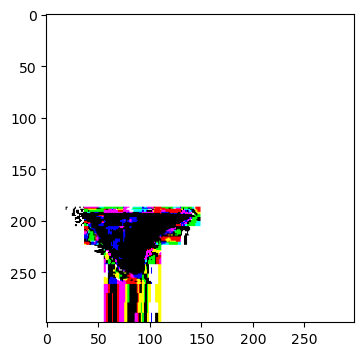

In [9]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

In [10]:
#List of metrics for monitoring
METRICS = [
      tfk.metrics.TruePositives(name='tp'),
      tfk.metrics.FalsePositives(name='fp'),
      tfk.metrics.TrueNegatives(name='tn'),
      tfk.metrics.FalseNegatives(name='fn'), 
      tfk.metrics.BinaryAccuracy(name='accuracy'),
      tfk.metrics.Precision(name='precision'),
      tfk.metrics.Recall(name='recall'),
      tfk.metrics.AUC(name='auc'),
      tfk.metrics.AUC(name='prc', curve='PR')
]

In [11]:
incresnet.trainable = False

inputs = tfk.Input(shape=(299,299,3))

model = incresnet(inputs)

# Rebuild top
x = tfkl.GlobalAveragePooling2D(name="avg_pool")(model)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name="IncResnet")
optimizer = tfk.optimizers.Adam()
tl_model.compile(
    optimizer=optimizer, loss=tfk.losses.CategoricalCrossentropy(), metrics=METRICS
)


In [15]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('inception_resnet_v2').layers[-14:]):
    #Keep BatchNormalization layer
    if not isinstance(layer, tfkl.BatchNormalization):
        layer.trainable = True
for i, layer in enumerate(tl_model.get_layer('inception_resnet_v2').layers):
    print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 Fal

In [13]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('logs/incresnet')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

  # Model checkpoint
  # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

  # Early Stopping
  # we use validation PRC to monitor our training process
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                   patience=5, 
                                                   mode = "max",
                                                   verbose=0,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

In [14]:
tf.get_logger().setLevel('WARNING') 
tf.get_logger().setLevel('ERROR') 

# Create folders and callbacks and fit
train_callbacks = create_folders_and_callbacks(model_name='incresnet')

# Train the model
tl_history = tl_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = train_callbacks
).history

Epoch 1/200
   2/1052 [..............................] - ETA: 38:14 - loss: 2.7704 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1664.0000 - fn: 128.0000 - accuracy: 0.9286 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4844 - prc: 0.0674

KeyboardInterrupt: 

In [50]:
# Save best epoch model
tl_model.save("best_model/incresnetBest")

In [16]:
del tl_model

In [17]:
tl_model = tfk.models.load_model("best_model/incresnetBest")

In [18]:
#Model prediction
predictions = tl_model.predict(valid_gen)
y_pred = np.argmax(predictions, axis=1)

In [19]:
#Defining function for confusion matrix plot
y_true = valid_gen.classes
classes = labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):


    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Accuracy: 0.9783
Precision: 0.9737
Recall: 0.984
F1: 0.9787
Normalized confusion matrix


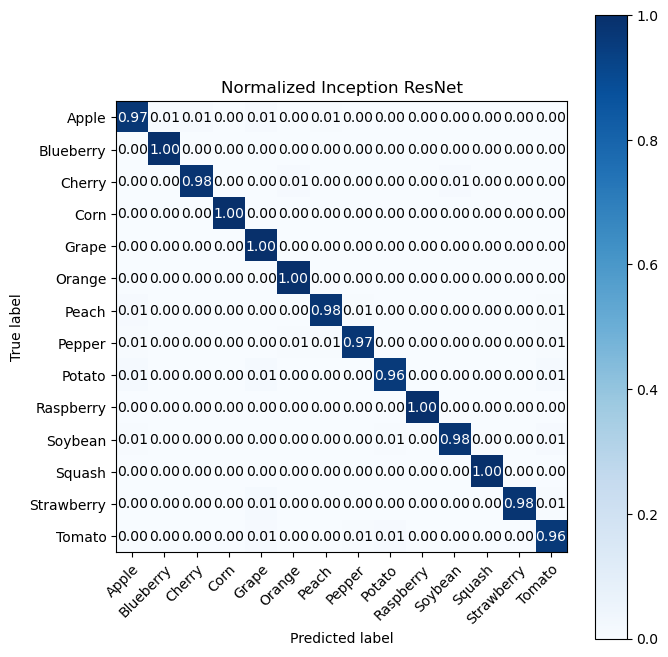

In [20]:
#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))


plot_confusion_matrix(y_true, y_pred, classes=labels, normalize = True,
                      title='Normalized Inception ResNet')
#plt.savefig('InceptionResnet.png')
plt.show()